# Tunneling of fermionic atoms

In this notebook we take a look at how fermionic atoms can tunnel in cold atomic experiments, based on the paper "Two Fermions in a Double Well: Exploring a Fundamental Building Block of the Hubbard Model" from the Jochim group [[1]](#References). In these experiments, two fermions of different spins are put into a single tweezer and then coupled to a second tweezer. The paper [[1]](#References) shows experimental data on how the atom number in the second tweezer evolves with time. It is therefore a very pedagogical example that exemplifies the possibilities of controlling single fermions in cold atomic gases.

As mentioned in the [third tutorial](./03_fermionic_tweezer_hardware.ipynb#Gates-and-dynamics), the physical dynamics of the 1-D tweezer array are governed by a Fermi-Hubbard Hamiltonian in second quantization: 

$$ 
 H_{\text{FH}}(\boldsymbol{J},U,\boldsymbol{\Delta}) =  \underbrace{-J\sum_{\sigma}(f^\dagger_{L,\sigma} f_{R,\sigma} + f^\dagger_{R,\sigma} f_{L,\sigma} )}_{\text{Tunneling/Hopping}} + \underbrace{U \left( n_{L,\uparrow}n_{L,\downarrow}+n_{R,\uparrow}n_{R,\downarrow}\right)}_{\text{interaction}} + \underbrace{\Delta\left(\sum_{\sigma}(n_{L,\sigma}-n_{R,\sigma} \right)}_{\text{potential offset}} 
$$

Here, $f_{i,\sigma}, f^\dagger_{i,\sigma}$ are annihilation/creation operators for atoms in tweezers at site $i=L, R$ (left/right) with spin $\sigma$ and $n_{i,\sigma} = f^\dagger_{i,\sigma} f_{i,\sigma}$ is the number operator. Note that here, we replaced $\mu$ by $\Delta$ to adapt to the notation of the paper [[1]](#References). The details about the different terms in the Hamiltonian are available in the [third tutorial](./03_fermionic_tweezer_hardware.ipynb#Gates-and-dynamics).

This notebook is structured as follows:
1. We will understand the experiments in a simple Hamiltonian description that includes only four levels and compare the predictions to the experimental data.
2. We will then show how you can simulate these experiments on your own laptop through `qiskit_cold_atom`.
3. In the last section, we show how to send such calculations to a cloud simulator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Analytical prediction

The evolution of the fermions under the Fermi-Hubbard Hamiltonian preserves the total number of particles, the total number of spin up particles and the total number of spin down particles. Owing to these conserved quantities, the Hamiltonian takes a block diagonal form in the occupation number basis. These blocks represent various sectors which are not coupled by the Hamiltonian.

For the current example we initialize the system in the sector $N=2,S_z=0$ (two atoms : one each for spin up and down). The dynamics of the system are limited to this subspace which is 4-dimensional. The Hamiltonian matrix in the subspace can be written down in the occupation number basis $\{LL, LR, RL, RR\}$ as:
$$
H = \left(\begin{array}{cccc}
U+2\Delta & -J & -J & 0\\
-J & 0 & 0 &-J\\
-J & 0 & 0 &-J\\
0 & -J & -J & U-2\Delta
            \end{array}
            \right)
$$ 

where $L$ and $R$ denote the left and right tweezer respectively. In the remainder of the notebook, we consider the case for $\Delta = 0$, so the Hamiltonian matrix reads:

$$
H = \left(\begin{array}{cccc}
U & -J & -J & 0\\
-J & 0 & 0 &-J\\
-J & 0 & 0 &-J\\
0 & -J & -J & U
            \end{array}
            \right)
$$

The experimental sequence is the following:

1. Both atoms are prepared in the left tweezer, such that the initial state is the basis state $|\psi(0)\rangle = |LL\rangle$.
2. The atoms evolve under the Hamiltonian $H$ with the parameters $J/\hbar = \pi \cdot 134$  and $U = 0.7\cdot J$ or $U=0$ (later called the non-interacting case).
3. The number of atoms in the right tweezer is read out in the end.

Given the simple matrix structure of the problem we can directly solve it by computing the time evolution, i.e., exponentiating the Hamiltonian.

In [2]:
# the experimental parameters
J = np.pi * 134  # hopping parameter in units of hbar
U = 0.7 * J  # interaction parameter

Nt_an = 50  # number of time steps for plotting
t_analytical = np.linspace(0, 25, Nt_an) * 1e-3  # evolution times

Let's define the Hamiltonian matrices as well as the initial state.

In [3]:
H_with_int = np.array([[U, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, U]])
H_wo_int = np.array([[0, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, 0]])

psi0 = np.zeros(4) * 1j
psi0[0] = 1.0

Now, we have assembled all the necessary tools to directly calculate the probabilites of the different occupation numbers from:

$$
|\psi(t)\rangle = e^{-i \hat{H}t/\hbar}|\psi(0)\rangle
$$

In [4]:
from scipy.linalg import expm

psis_wo_int = 1j * np.zeros((4, Nt_an))
psis_w_int = 1j * np.zeros((4, Nt_an))

for i, ti  in enumerate(t_analytical):

    U_wo = expm(-1j * ti * H_wo_int)
    psis_wo_int[:, i] = np.dot(U_wo, psi0)

    U_w = expm(-1j * ti * H_with_int)
    psis_w_int[:, i] = np.dot(U_w, psi0)

pops_wo = np.abs(psis_wo_int) ** 2
pops_w = np.abs(psis_w_int) ** 2

In the final step, we have to assamble the observed quantity, i.e., the expectation value of the atoms in the right tweezer $\langle \hat{n}_{,R} \rangle$, from the calculated probabilities.

In [5]:
nR_wo = pops_wo[1, :] + pops_wo[2, :] + 2 * pops_wo[3, :]
nR_w = pops_w[1, :] + pops_w[2, :] + 2 * pops_w[3, :];

At this stage, we are now ready to compare our calculations to the experimental observations, which we have extracted from the paper saved in the following arrays.

In [6]:
# raw values on experiments without interactions from the paper by Murmann et al.
no_int_time = np.array(
    [0.0, 0.84951456, 1.52912621, 2.20873786, 3.05825243, 4.0776699, 4.75728155, 5.26699029, 6.28640777, 6.7961165, 7.64563107, 8.32524272, 9.00485437, 9.85436893, 10.53398058, 11.38349515, 12.0631068, 12.74271845, 13.4223301, 14.27184466, 14.95145631, 15.80097087, 16.48058252, 17.16019417, 18.00970874, 18.68932039, 19.53883495, 20.2184466, 21.06796117, 21.74757282, 22.42718447, 23.27669903, 23.95631068, 24.80582524,]
)

no_int_nR = np.array(
    [0.07042254, 0.56338028, 1.23943662, 1.43661972, 1.8028169, 1.57746479, 1.22535211, 0.81690141, 0.42253521, 0.21126761, 0.07042254, 0.43661972, 0.73239437, 1.33802817, 1.66197183, 1.66197183, 1.36619718, 0.85915493, 0.6056338, 0.07042254, 0.14084507, 0.42253521, 0.67605634, 1.28169014, 1.36619718, 1.54929577, 1.4084507, 1.07042254, 0.57746479, 0.36619718, 0.1971831, 0.28169014, 0.49295775, 0.92957746,]
)

# raw values on experiments with interactions from the paper by Murmann et al.
with_int_time = np.array(
    [-0.16990291, 0.84951456, 1.52912621, 2.03883495, 2.88834951, 3.73786408, 4.41747573, 5.94660194, 5.09708738, 6.62621359, 7.47572816, 8.15533981, 9.00485437, 9.68446602, 10.53398058, 11.21359223, 11.89320388, 12.74271845, 13.4223301, 14.27184466, 14.95145631, 15.63106796, 16.48058252, 17.16019417, 18.00970874, 18.68932039, 19.36893204, 20.2184466, 21.06796117, 21.74757282, 22.42718447, 23.27669903, 23.95631068, 24.63592233, 25.48543689, 26.16504854, 27.01456311, 27.69417476,]
)

with_int_nR = np.array(
    [0.06896552, 0.35862069, 1.00689655, 1.35172414, 1.42068966, 1.35172414, 1.28275862, 1.00689655, 0.85517241, 0.56551724, 0.35862069, 0.57931034, 0.8, 0.8, 0.99310345, 1.2, 1.14482759, 0.99310345, 1.46206897, 1.43448276, 1.48965517, 1.07586207, 0.92413793, 0.75862069, 0.28965517, 0.4, 0.60689655, 0.64827586, 1.42068966, 1.35172414, 1.25517241, 1.35172414, 1.06206897, 0.71724138, 0.42758621, 0.28965517, 0.37241379, 0.35862069,]
)

And now, we can observe a beautiful agreement between the predicted evolution and the experimentally observed quantities:

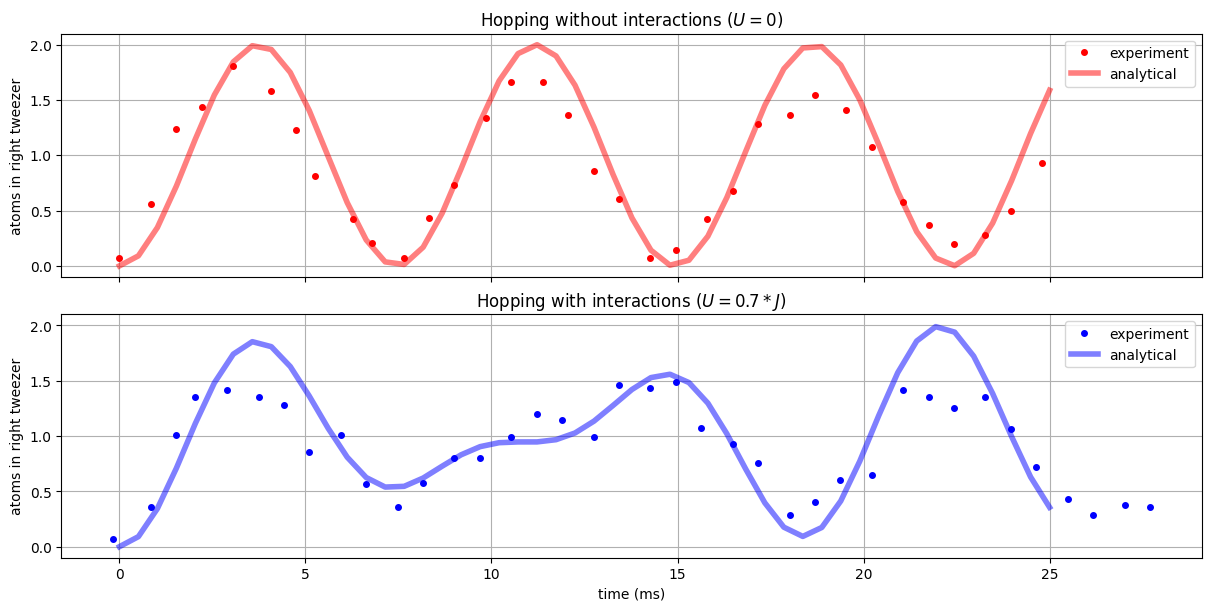

In [7]:
f, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, sharey=True, figsize=(12, 6), constrained_layout=True
)

ax1.plot(no_int_time, no_int_nR, "ro", label="experiment", markersize=4)
ax1.plot(t_analytical * 1e3, nR_wo, "r-", label="analytical", linewidth=4, alpha=0.5)

ax2.plot(with_int_time, with_int_nR, "bo", label="experiment", markersize=4)
ax2.plot(t_analytical * 1e3, nR_w, "b-", label="analytical", linewidth=4, alpha=0.5)

ax1.set_ylabel(r"atoms in right tweezer")
ax2.set_ylabel(r"atoms in right tweezer")
ax2.set_xlabel(r"time (ms)")
# ax2.set_xlim(0, 20)
ax1.set_title(r"Hopping without interactions ($U=0$)")
ax2.set_title(r"Hopping with interactions ($U=0.7*J$)")
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()

These dynamics have an intuitive explanation: Without interaction, both atoms tunnel back and forth between $|L\rangle$ and $|R\rangle$ at the same rate, which leads to sinusoidal interactions. With interaction, the atoms repel each other (as $U>0$) whichs forms a complicated beating pattern of the tunneling. 

## Simulation with `qiskit_cold_atom`

While the previous approach works out quite nicely for this simple example, it requires the user to have a good understanding of the numerical methods, which are adapted to simulate the experiment and does not connect directly to the gate based approach. We will now show that the experiment presented above can be described in a circuit language using `qiskit_cold_atom`. For a first introduction to fermionic circuits, please see the [first tutorial](./01_introduction_and_fermionic_circuits.ipynb).

In [8]:
from qiskit_cold_atom.fermions import FermionSimulator
from qiskit_cold_atom.fermions.fermion_gate_library import FermiHubbard
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit.circuit import Parameter

backend = FermionSimulator()

For a circuit description of the two-tweezer experiment, we first initialize the circuit with the correct number and location of atoms. Then we apply a Fermi-Hubbard gate which captures the full dynamics of the system. 

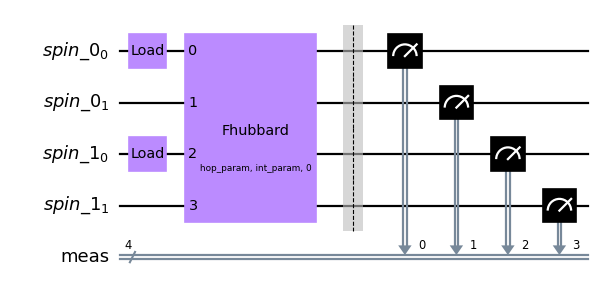

In [9]:
hop_param = Parameter("hop_param")
int_param = Parameter("int_param")

# initialize one spin-up and one spin-down atom in the left tweezer
qc = backend.initialize_circuit([[1, 0], [1, 0]])
# apply a global Fermi-Hubbard gate with interaction
qc.fhubbard(j=[hop_param], u=int_param, mu=[0],modes=range(4))

qc.measure_all()

qc.draw(output="mpl", scale=0.8)

To directly simulate the experiment, we run a list of circuits with different evolution times on the simulator backend. 

In [10]:
Ntimes = 50
times = np.linspace(0, 25, Ntimes) * 1e-3

In [11]:
# create list of circuits without interaction
circuits_no_int = [qc.bind_parameters({hop_param: J*t, int_param: 0}) for t in times]
# measure the observable from simulated shots
job_no_int = backend.run(circuits_no_int, shots=1000)

In [12]:
# create list of circuits without interaction
circuits_int = [qc.bind_parameters({hop_param: J*t, int_param: U*t}) for t in times]
# measure the observable from simulated shots
job_int = backend.run(circuits_int, shots=1000)

In [13]:
# extract the observable from the measured data
def mean_counts_right(job, N_circs):
    """Compute the average number of number of atoms in the right tweezer."""
    
    result = job.result()
    
    mean_counts = []
    for i in range(N_circs):
        outcomes = result.get_memory(i)
        right_counts = 0
        for outcome in outcomes:
            outcome_string = "".join(outcome.split())
            # select spin-up (idx 1) and spin-down (idx 3) of the right tweezer
            right_counts += (int(outcome_string[1]) + int(outcome_string[3]))          
        mean_counts.append(right_counts/len(outcomes))
                             
    return mean_counts

In [14]:
means_no_int = mean_counts_right(job_no_int, Ntimes)
means_int = mean_counts_right(job_int, Ntimes)

Let's compare the Qiskit simulations to the experimental data and the numerical model from above:

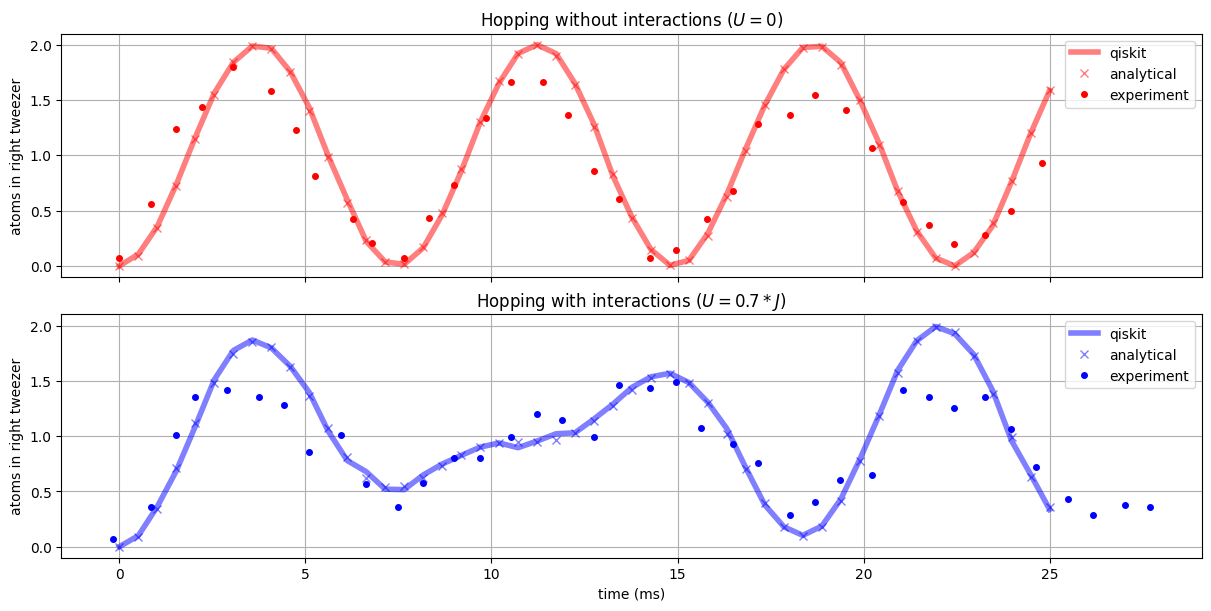

In [15]:
f, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, sharey=True, figsize=(12, 6), constrained_layout=True
)


ax1.plot(times * 1e3, means_no_int, "r-", label="qiskit", linewidth=4, alpha=0.5)
ax1.plot(t_analytical * 1e3, nR_wo, "rx", label="analytical", linewidth=4, alpha=0.5)
ax1.plot(no_int_time, no_int_nR, "ro", label="experiment", markersize=4)

ax2.plot(times * 1e3, means_int, "b-", label="qiskit", linewidth=4, alpha=0.5)
ax2.plot(t_analytical * 1e3, nR_w, "bx", label="analytical", linewidth=4, alpha=0.5)
ax2.plot(with_int_time, with_int_nR, "bo", label="experiment", markersize=4)
ax1.set_ylabel(r"atoms in right tweezer")
ax2.set_ylabel(r"atoms in right tweezer")
ax2.set_xlabel(r"time (ms)")
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
# ax1.set_xlim(-1, 20)
ax1.set_title(r"Hopping without interactions ($U=0$)")
ax2.set_title(r"Hopping with interactions ($U=0.7*J$)")
ax1.grid()
ax2.grid();

We see that Qiskit's simulator allows to obtain the analytical predicition in an easy and intuitive way. The slight deviations arise from the sampling with a finite shot number.

## Optional: Working on a cloud simulator

We would also like to send such circuits to some real hardware and investigate these results. In this last section, we will present this possibility with the [alqor provider](https://qlued.alqor.io) . 

<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells in this part of the tutorial that interface with a remote device backend, you'll need to have a registered account with a valid username and password for this provider which can be obtained at the URL linked above.</div>

In a first step, it is necessary to import the cold atom provider.

In [16]:
from qiskit_cold_atom.providers import ColdAtomProvider
from qiskit.circuit import QuantumCircuit, Parameter

Saving/enabling your synqs backend credentials (Optional if not alreayd done).

In [1]:
# save an account to disk
#provider = ColdAtomProvider.save_account(
#    url=[
#        "https://qlued.alqor.io/api/v1/singlequdit",
#        "https://qlued.alqor.io/api/v1/multiqudit",
#        "https://qlued.alqor.io/api/v1/fermions",
#    ],
#    username="name",
#    token="password",
#)

# or enable an account in the current session
#provider = ColdAtomProvider.enable_account(
#    url=[
#        "https://qlued.alqor.io/api/v1/singlequdit",
#        "https://qlued.alqor.io/api/v1/multiqudit",
#        "https://qlued.alqor.io/api/v1/fermions",    ],
#    username="name",
#    token="password",
#)

We can now access the remote fermionic simulator.

In [17]:
provider = ColdAtomProvider.load_account()
fermion_device_backend = provider.get_backend("alqor_fermionic_tweezer_simulator")
print(fermion_device_backend.configuration().supported_instructions)

['load', 'barrier', 'fhop', 'fint', 'fphase', 'measure']


__Note: synqs' fermion backend uses a different notation convention for the spin species in a fermionic circuit, where the spin-up and spin-down wires alternate.__

### No interaction
In a first set of experiments there are no interactions and the two atoms are simply allowed to hop. The experiment is then described by the following, simple circuit.

In [18]:
theta_j = Parameter("theta_j")

In [19]:
# the parameters of the experiment
J = np.pi * 134
Ntimes = 15
times = np.linspace(0, 20, Ntimes) * 1e-3
theta_js = -1 * J * times
means = np.zeros(Ntimes)

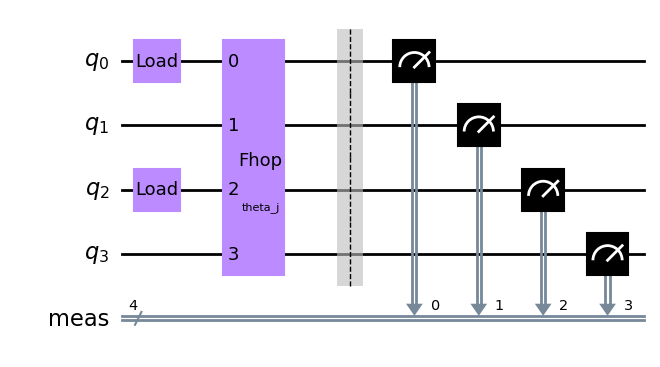

In [20]:
circuit1 = QuantumCircuit(4)
circuit1.fload(0)
circuit1.fload(2)
circuit1.fhop([theta_j], list(range(0, 4)))
circuit1.measure_all()
circuit1.draw(output="mpl")

In [21]:
circuit1_list = [circuit1.bind_parameters({theta_j: theta % (2 * np.pi)}) for theta in theta_js]

In [22]:
job1 = fermion_device_backend.run(circuit1_list, shots=500)

In [23]:
job_retrieved1 = fermion_device_backend.retrieve_job(job_id=job1.job_id())

print("job status: ", job_retrieved1.status())

job status:  JobStatus.INITIALIZING


In [24]:
means = mean_counts_right(job_retrieved1, Ntimes)

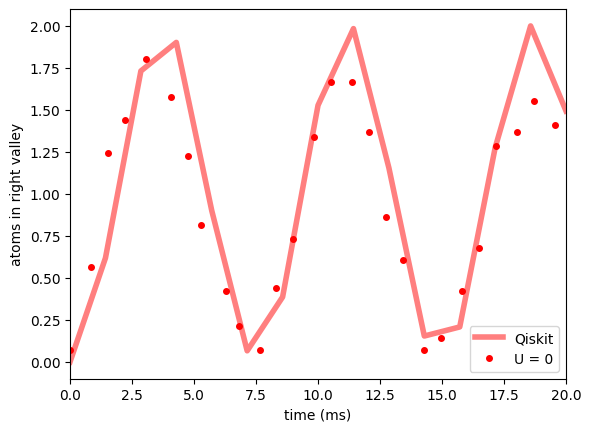

In [25]:
f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
ax1.plot(times * 1e3, means, "r-", label="Qiskit", linewidth=4, alpha=0.5)
ax1.plot(no_int_time, no_int_nR, "ro", label="U = 0", markersize=4)
ax1.set_ylabel(r"atoms in right valley")
ax1.set_xlabel(r"time (ms)")
ax1.legend()
ax1.set_xlim(0, 20);

### Hopping with interactions

In a next step, the atoms are interacting.
As you can see, this backend is only implementing a limited set of gates. 
To simulate the simultaneous hopping and interaction, the circuit has to be trotterized.

In [26]:
theta_j = Parameter("theta_j")
theta_u = Parameter("theta_u")

# the parameters of the experiment
J = np.pi * 134
U = 0.7 * J
Ntimes = 15
times = np.linspace(0, 20, Ntimes) * 1e-3
theta_js = -1 * J * times
theta_us = U * times
means_int = np.zeros(Ntimes)
Ntrott = 14

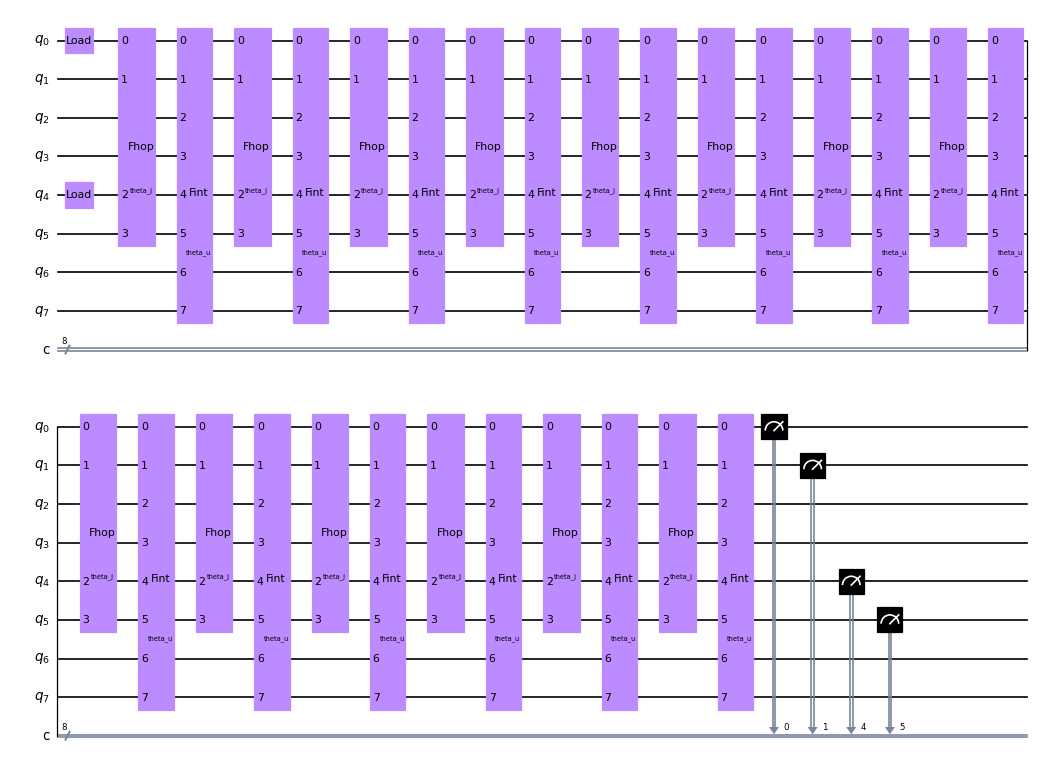

In [27]:
circuit2 = QuantumCircuit(8, 8)
circuit2.fload(0)
circuit2.fload(4)
for ii in range(Ntrott):
    circuit2.fhop([theta_j], [0, 1, 4, 5])
    circuit2.fint(theta_u, list(range(0, 8)))

for idx in [0, 1, 4, 5]:
    circuit2.measure(idx, idx)

circuit2.draw(output="mpl", scale=0.6)

next we set up the circuits that calculate each time step and send it to the backend

In [28]:
circuit2_list = [
    circuit2.bind_parameters(
        {
            theta_j: (theta1 / Ntrott) % (2 * np.pi),
            theta_u: (theta2 / Ntrott) % (2 * np.pi),
        }
    )
    for (theta1, theta2) in zip(theta_js, theta_us)
]
job2 = fermion_device_backend.run(circuit2_list, shots=500)

You can now save the job and wait until the job status has changed to done. 

In [29]:
job_retrieved2 = fermion_device_backend.retrieve_job(job_id=job2.job_id())
print("job status: ", job_retrieved2.status())

job status:  JobStatus.INITIALIZING


Once the job is done, we can obtain once again the usual results, which are saved on the backend.

(0.0, 20.0)

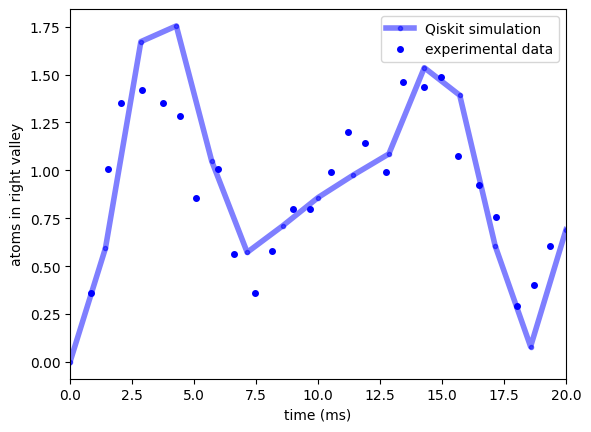

In [30]:
means_int = mean_counts_right(job_retrieved2, Ntimes)

f, ax2 = plt.subplots(1, 1, sharex=True, sharey=True)

ax2.plot(times * 1e3, means_int, "b.-", label="Qiskit simulation", linewidth=4, alpha=0.5)
ax2.plot(
    with_int_time,
    with_int_nR,
    "bo",
    label="experimental data",
    markersize=4,
)
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax2.legend()
ax2.set_xlim(0, 20)

## References

[1] [Simon Murmann et al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.080402) *Two Fermions in a Double Well: Exploring a Fundamental Building Block of the Hubbard Model*. Phys. Rev. Lett. 114, 080402 (2015).

In [31]:
import qiskit.tools.jupyter

%qiskit_version_table